# Analyzing RCT data with Precision Adjustment

In [ ]:
#import Pkg


#Pkg.add("DataFrames")
#Pkg.add("FilePaths")
#Pkg.add("Queryverse")
#Pkg.add("GLM")
#Pkg.add("StatsModels")
#Pkg.add("Combinatorics")
#Pkg.add("Iterators")
#Pkg.add("CategoricalArrays")
#Pkg.add("StatsBase")
#Pkg.add("Lasso")
#Pkg.add("TypedTables")
#Pkg.add("MacroTools")
#Pkg.add("NamedArrays")
#Pkg.add("DataTables")
#Pkg.add("Latexify")
#Pkg.add("PrettyTables")
#Pkg.add("TypedTables")
#Pkg.add("TexTables")
#Pkg.add("StatsModels")
#Pkg.add("DataTables")
#Pkg.add("FilePaths")
#Pkg.add("Combinatorics")
#Pkg.add("CategoricalArrays")
#Pkg.add("TypedTables")
#+-Pkg.add("MacroTools")
#import Pkg; Pkg.add("DataTables")
#import Pkg; Pkg.add("Lasso")
#import Pkg; Pkg.add("Combinatorics")
#import Pkg; Pkg.add("StatsBase")
#import Pkg; Pkg.add("TypedTables")
#import Pkg; Pkg.add("MacroTools")
#import Pkg; Pkg.add("NamedArrays")
#import Pkg; Pkg.add("PrettyTables")
#import Pkg; Pkg.add("TexTables")
import Pkg
Pkg.add("DataFrames")
Pkg.add("CausalInference")
Pkg.add("Graphs")
Pkg.add("Test")
Pkg.add("Statistics")
Pkg.add("CairoMakie")
Pkg.add("GraphMakie")
Pkg.add("StatsModels")
using GLM, StatsModels
using DataTables
using DelimitedFiles
using DataFrames
using Lasso
using FilePaths
using StatsModels, Combinatorics
using CategoricalArrays
using StatsBase, Statistics
using TypedTables
using MacroTools
using NamedArrays
using PrettyTables # Dataframe or Datatable to latex
using TexTables # pretty regression table and tex outcome

In [ ]:
# Loading data
using DelimitedFiles

mat, head = readdlm("C:/Users/pamelacubas/Downloads/penn_jae.dat", header=true, Float64)
mat
df =DataFrame(mat, vec(head))
describe(df)

23×7 DataFrame
 Row │ variable    mean            min      median   max      nmissing  eltype ⋯
     │ Symbol      Float64         Float64  Float64  Float64  Int64     DataTy ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ abdt        10693.6         10404.0  10691.0  10880.0         0  Float6 ⋯
   2 │ tg              2.56889         0.0      2.0      6.0         0  Float6
   3 │ inuidur1       12.9148          1.0     10.0     52.0         0  Float6
   4 │ inuidur2       12.1938          0.0      9.0     52.0         0  Float6
   5 │ female          0.402142        0.0      0.0      1.0         0  Float6 ⋯
   6 │ black           0.116653        0.0      0.0      1.0         0  Float6
   7 │ hispanic        0.0363689       0.0      0.0      1.0         0  Float6
   8 │ othrace         0.00575002      0.0      0.0      1.0         0  Float6
   9 │ dep             0.444045        0.0      0.0      2.0         0  Float6 ⋯
  10 │ q1              0.0136563       0.0      0.0      1.0         0  Float6
  11 │ q2              0.206498        0.0      0.0      1.0         0  Float6
  ⋮  │     ⋮             ⋮            ⋮        ⋮        ⋮        ⋮         ⋮   ⋱
  14 │ q5              0.232948        0.0      0.0      1.0         0  Float6
  15 │ q6              0.0769784       0.0      0.0      1.0         0  Float6 ⋯
  16 │ recall          0.108675        0.0      0.0      1.0         0  Float6
  17 │ agelt35         0.543089        0.0      1.0      1.0         0  Float6
  18 │ agegt54         0.106735        0.0      0.0      1.0         0  Float6
  19 │ durable         0.148638        0.0      0.0      1.0         0  Float6 ⋯
  20 │ nondurable      0.10961         0.0      0.0      1.0         0  Float6
  21 │ lusd            0.265435        0.0      0.0      1.0         0  Float6
  22 │ husd            0.221807        0.0      0.0      1.0         0  Float6
  23 │ muld            0.438008        0.0      0.0      1.0         0  Float6 ⋯
                                                     1 column and 2 rows omitted

In [ ]:
#dimenntions of dataframe 

a = size(df,1)
b =  size(df,2)

23

In [ ]:
# Filter control group and just treatment group number 2

penn = filter(row -> row[:tg] in [2,0], df)

first(penn,20)

20×23 DataFrame
 Row │ abdt     tg       inuidur1  inuidur2  female   black    hispanic  othra ⋯
     │ Float64  Float64  Float64   Float64   Float64  Float64  Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 10824.0      0.0      18.0      18.0      0.0      0.0       0.0      0 ⋯
   2 │ 10635.0      2.0       7.0       3.0      0.0      0.0       0.0      0
   3 │ 10824.0      0.0       1.0       1.0      0.0      0.0       0.0      0
   4 │ 10747.0      0.0      27.0      27.0      0.0      0.0       0.0      0
   5 │ 10754.0      2.0      20.0      20.0      1.0      0.0       0.0      0 ⋯
   6 │ 10831.0      0.0      27.0      27.0      0.0      0.0       0.0      0
   7 │ 10845.0      0.0      27.0      27.0      1.0      0.0       0.0      0
   8 │ 10831.0      0.0       9.0       9.0      1.0      0.0       0.0      0
   9 │ 10859.0      0.0      27.0      27.0      1.0      0.0       0.0      0 ⋯
  10 │ 10628.0      2.0      27.0      27.0      0.0      0.0       0.0      0
  11 │ 10516.0      0.0      15.0      15.0      1.0      0.0       0.0      0
  12 │ 10803.0      2.0       3.0       3.0      1.0      0.0       0.0      0
  13 │ 10663.0      0.0      28.0      11.0      1.0      0.0       0.0      0 ⋯
  14 │ 10747.0      0.0      12.0      12.0      1.0      0.0       0.0      0
  15 │ 10635.0      2.0      17.0      10.0      1.0      0.0       0.0      0
  16 │ 10761.0      2.0      13.0      13.0      0.0      0.0       0.0      0
  17 │ 10768.0      0.0      18.0      18.0      1.0      0.0       0.0      0 ⋯
  18 │ 10537.0      0.0       1.0       1.0      1.0      0.0       0.0      0
  19 │ 10789.0      2.0      34.0       7.0      0.0      0.0       0.0      0
  20 │ 10775.0      2.0      11.0      11.0      0.0      0.0       0.0      0
                                                              16 columns omitted

Focus on the Treatment group 2

In [ ]:
# Treatment group n°2
replace!(penn.tg, 2 => 1)


rename!(penn, "tg" => "T2")


# from float to string
penn[!,:dep] = string.(penn[!,:dep]) 

# dep varaible in categorical format 
penn[!,:dep] = categorical(penn[!,:dep])

describe(penn)

first(penn,10)

10×23 DataFrame
 Row │ abdt     T2       inuidur1  inuidur2  female   black    hispanic  othra ⋯
     │ Float64  Float64  Float64   Float64   Float64  Float64  Float64   Float ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 10824.0      0.0      18.0      18.0      0.0      0.0       0.0      0 ⋯
   2 │ 10635.0      1.0       7.0       3.0      0.0      0.0       0.0      0
   3 │ 10824.0      0.0       1.0       1.0      0.0      0.0       0.0      0
   4 │ 10747.0      0.0      27.0      27.0      0.0      0.0       0.0      0
   5 │ 10754.0      1.0      20.0      20.0      1.0      0.0       0.0      0 ⋯
   6 │ 10831.0      0.0      27.0      27.0      0.0      0.0       0.0      0
   7 │ 10845.0      0.0      27.0      27.0      1.0      0.0       0.0      0
   8 │ 10831.0      0.0       9.0       9.0      1.0      0.0       0.0      0
   9 │ 10859.0      0.0      27.0      27.0      1.0      0.0       0.0      0 ⋯
  10 │ 10628.0      1.0      27.0      27.0      0.0      0.0       0.0      0
                                                              16 columns omitted

 Plot two histograms for treatment and control group to see the distribution of the outcome variable inuidur1

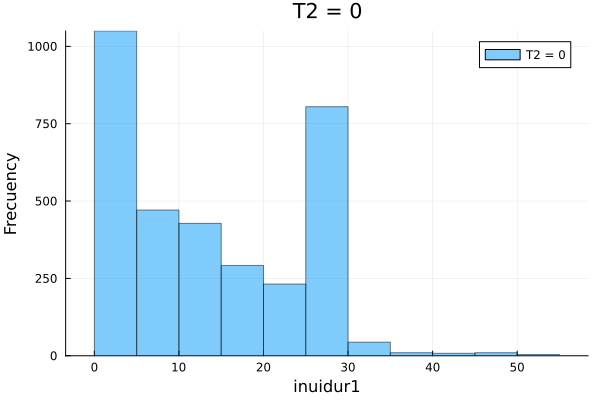

In [ ]:
using DataFrames
using Plots
using StatsPlots

penn_t2_0 = filter(row -> row.T2 == 0, penn)
penn_t2_1 = filter(row -> row.T2 == 1, penn)

# Crear los histogramas
histogram(penn_t2_0.inuidur1, label="T2 = 0", alpha=0.5)

xlabel!("inuidur1")
ylabel!("Frecuency")
title!("T2 = 0")

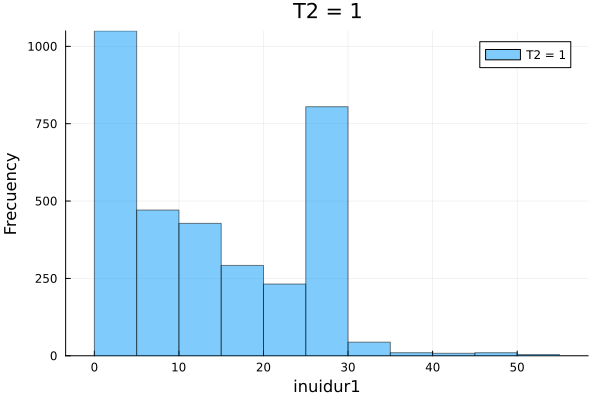

In [ ]:
histogram(penn_t2_0.inuidur1, label="T2 = 1", alpha=0.5)

xlabel!("inuidur1")
ylabel!("Frecuency")
title!("T2 = 1")

Covariate Balance Check

In [ ]:
    # couples variables combinations 
    combinations_upto(x, n) = Iterators.flatten(combinations(x, i) for i in 1:n)

    # combinations without same couple
    expand_exp(args, deg::ConstantTerm) =
        tuple(((&)(terms...) for terms in combinations_upto(args, deg.n))...)

    StatsModels.apply_schema(t::FunctionTerm{typeof(^)}, sch::StatsModels.Schema, ctx::Type) =
        apply_schema.(expand_exp(t.args_parsed...), Ref(sch), ctx)

In [ ]:
reg1 = @formula(T2 ~ (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable)^2)
reg1 = apply_schema(reg1, schema(reg1, penn))

FormulaTerm
Response:
  T2(continuous)
Predictors:
  female(continuous)
  black(continuous)
  othrace(continuous)
  dep(DummyCoding:3→2)
  q2(continuous)
  q3(continuous)
  q4(continuous)
  q5(continuous)
  q6(continuous)
  agelt35(continuous)
  agegt54(continuous)
  durable(continuous)
  female(continuous) & black(continuous)
  female(continuous) & othrace(continuous)
  female(continuous) & dep(DummyCoding:3→2)
  female(continuous) & q2(continuous)
  female(continuous) & q3(continuous)
  female(continuous) & q4(continuous)
  female(continuous) & q5(continuous)
  female(continuous) & q6(continuous)
  female(continuous) & agelt35(continuous)
  female(continuous) & agegt54(continuous)
  female(continuous) & durable(continuous)
  black(continuous) & othrace(continuous)
  black(continuous) & dep(DummyCoding:3→2)
  black(continuous) & q2(continuous)
  black(continuous) & q3(continuous)
  black(continuous) & q4(continuous)
  black(continuous) & q5(continuous)
  black(continuous) & q6(continu

In [ ]:
m1 = lm(reg1, penn)
table = regtable( "Covariate Balance Check" => m1) # coeficientes, standar error, squared R, N (sample size )

                   | Covariate Balance Check 
                   |           (1)           
---------------------------------------------
       (Intercept) |                0.500*** 
                   |                 (0.137) 
            female |                   0.024 
                   |                 (0.125) 
             black |                  -0.034 
                   |                 (0.084) 
           othrace |                   0.101 
                   |                 (0.289) 
          dep: 1.0 |                   0.141 
                   |                 (0.179) 
          dep: 2.0 |                  -0.189 
                   |                 (0.156) 
                q2 |                  -0.068 
                   |                 (0.140) 
                q3 |                  -0.081 
                   |                 (0.139) 
                q4 |                  -0.054 
                   |                 (0.140) 
                q5 |              

In [ ]:
m1

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

T2 ~ 1 + female + black + othrace + dep + q2 + q3 + q4 + q5 + q6 + agelt35 + agegt54 + durable + female & black + female & othrace + female & dep + female & q2 + female & q3 + female & q4 + female & q5 + female & q6 + female & agelt35 + female & agegt54 + female & durable + black & othrace + black & dep + black & q2 + black & q3 + black & q4 + black & q5 + black & q6 + black & agelt35 + black & agegt54 + black & durable + othrace & dep + othrace & q2 + othrace & q3 + othrace & q4 + othrace & q5 + othrace & q6 + othrace & agelt35 + othrace & agegt54 + othrace & durable + dep & q2 + dep & q3 + dep & q4 + dep & q5 + dep & q6 + dep & agelt35 + dep & agegt54 + dep & durable + q2 & q3 + q2 & q4 + q2 & q5 + q2 & q6 + q2 & agelt35 + q2 & agegt54 + q2 & durable + q3 & q4 + q3 & q5 + q3 & q6 + q3 & agelt35

### Model specification

Run all specifications:
classical 2-sample approach, no adjustment (CL)
classical linear regression adjustment (CRA)
interactive regression adjustment (IRA)
interactive regression adjustment (IRA) using Lasso. 

In [ ]:
# No adjustment (2-sample approach)

ols_cl = lm(@formula(log(inuidur1) ~ T2), penn)

table1 = regtable( "No adjustment model" => ols_cl)   # 

            | No adjustment model 
            |         (1)         
----------------------------------
(Intercept) |            2.057*** 
            |             (0.021) 
         T2 |            -0.079** 
            |             (0.032) 
----------------------------------
          N |               5,782 
      $R^2$ |               0.001 


In [ ]:
# adding controls
# Omitted dummies: q1, nondurable, muld

reg2 = @formula(log(inuidur1) ~ T2 + (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable)^2)
reg2 = apply_schema(reg2, schema(reg2, penn))

ols_cra = lm(reg2, penn)
table2 = regtable("CRA model" => ols_cra)

                   | CRA model 
                   |    (1)    
-------------------------------
       (Intercept) |  2.517*** 
                   |   (0.332) 
                T2 |  -0.075** 
                   |   (0.032) 
            female | -0.902*** 
                   |   (0.302) 
             black | -0.448*** 
                   |   (0.140) 
           othrace |    -0.260 
                   |   (1.069) 
          dep: 1.0 |     0.294 
                   |   (0.434) 
          dep: 2.0 |     0.233 
                   |   (0.377) 
                q2 |    -0.115 
                   |   (0.339) 
                q3 |    -0.466 
                   |   (0.338) 
                q4 |    -0.467 
                   |   (0.338) 
                q5 |    -0.380 
                   |   (0.337) 
                q6 |    -0.537 
                   |   (0.356) 
           agelt35 |    -0.303 
                   |   (0.313) 
           agegt54 |    -0.437 
                   |   (0.562) 
        

In [ ]:
# demean function
function desv_mean(a)
    A = mean(a, dims = 1)
    M = zeros(Float64, size(X,1), size(X,2))
    
    for i in 1:size(a,2)
          M[:,i] = a[:,i] .- A[i]
    end
    return M
end    

# Matrix Model & demean
X = StatsModels.modelmatrix(reg1.rhs,penn)
X = desv_mean(X) # matrix format 

5782×90 Matrix{Float64}:
 -0.400726  -0.118817  -0.00518852  -0.116569  …  0.0  -0.073504  -0.0188516
 -0.400726  -0.118817  -0.00518852  -0.116569     0.0  -0.073504  -0.0188516
 -0.400726  -0.118817  -0.00518852  -0.116569     0.0  -0.073504  -0.0188516
 -0.400726  -0.118817  -0.00518852  -0.116569     0.0  -0.073504  -0.0188516
  0.599274  -0.118817  -0.00518852  -0.116569     0.0  -0.073504  -0.0188516
 -0.400726  -0.118817  -0.00518852   0.883431  …  0.0  -0.073504   0.981148
  0.599274  -0.118817  -0.00518852  -0.116569     0.0  -0.073504  -0.0188516
  0.599274  -0.118817  -0.00518852   0.883431     0.0  -0.073504  -0.0188516
  0.599274  -0.118817  -0.00518852   0.883431     0.0  -0.073504  -0.0188516
 -0.400726  -0.118817  -0.00518852  -0.116569     0.0  -0.073504  -0.0188516
  0.599274  -0.118817  -0.00518852  -0.116569  …  0.0  -0.073504  -0.0188516
  0.599274  -0.118817  -0.00518852  -0.116569     0.0  -0.073504  -0.0188516
  0.599274  -0.118817  -0.00518852  -0.116569     0.

In [ ]:
Y = select(penn, [:inuidur1,:T2]) # select inuidur1 y T2

X = DataFrame(hcat(X, Matrix(select(penn, [:T2])).*X), :auto)  # Joint X, (T2*X)

base = hcat(Y, X) # Joint inuidur1, T2, X y (T2*X)

base.inuidur1 = log.(base.inuidur1)  # log(inuidur1)

terms = term.(names(base)) # term.() let us to get all variables as objects

#interactive regression model

ols_ira  = lm(terms[1] ~ sum(terms[2:end]), base)


table3 = regtable("Interactive model" => ols_ira)

#terms[1] : select first variable. In this case, oucome of interest 
#sum(terms[2:end]) : independent variables as regresors in the linear regression   
     

            | Interactive model 
            |        (1)        
--------------------------------
(Intercept) |          2.057*** 
            |           (0.021) 
         T2 |          -0.075** 
            |           (0.032) 
         x1 |            -0.604 
            |           (0.430) 
         x2 |         -0.794*** 
            |           (0.256) 
         x3 |            -1.482 
            |           (2.156) 
         x4 |            -0.005 
            |           (0.664) 
         x5 |             0.227 
            |           (0.475) 
         x6 |            -0.283 
            |           (0.474) 
         x7 |            -0.580 
            |           (0.473) 
         x8 |            -0.538 
            |           (0.474) 
         x9 |            -0.461 
            |           (0.472) 
        x10 |            -0.667 
            |           (0.493) 
        x11 |            -0.618 
            |           (0.418) 
        x12 |            -0.645 
          

In [ ]:
X = StatsModels.modelmatrix(reg2.rhs,penn)
X = desv_mean(X)


D = DataFrame([X[:,1]], :auto)  # Treatment varaible

rename!(D, Dict(:x1 => :T2)) #rename x1 -> T2

X = DataFrame(hcat(X[:,2:end], X[:,1].*X[:,2:end]), :auto)  # Join Controls (X) + T2*X "interactive"

Y = select(penn, [:inuidur1]) #select just inuidur1

Y.inuidur1 = log.(Y.inuidur1)  # log(inuidur1)


5782-element Vector{Float64}:
 2.8903717578961645
 1.9459101490553132
 0.0
 3.295836866004329
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.1972245773362196
 3.295836866004329
 3.295836866004329
 2.70805020110221
 1.0986122886681098
 3.332204510175204
 ⋮
 2.302585092994046
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.70805020110221
 0.0
 3.1354942159291497
 1.791759469228055
 2.6390573296152584
 2.1972245773362196
 1.3862943611198906
 3.295836866004329

In [ ]:
X

5782×180 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
   11 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671   0.799896  -0
  ⋮   │     ⋮          ⋮           ⋮           ⋮          ⋮          ⋮         ⋱
 5773 │  0.599274  -0.118817   0.994811    -0.116569  -0.160671   0.799896  -0
 5774 │  0.599274  -0.118817   0.994811    -0.116569  -0.160671  -0.200104  -0 ⋯
 5775 │  0.599274  -0.118817   0.994811    -0.116569  -0.160671  -0.200104  -0
 5776 │  0.599274  -0.118817   0.994811    -0.116569  -0.160671  -0.200104  -0
 5777 │ -0.400726   0.881183  -0.00518852  -0.116569  -0.160671  -0.200104  -0
 5778 │  0.599274  -0.118817   0.994811    -0.116569   0.839329  -0.200104  -0 ⋯
 5779 │ -0.400726   0.881183  -0.00518852  -0.116569  -0.160671  -0.200104  -0
 5780 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329   0.799896  -0
 5781 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
 5782 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
                                               174 columns and 5761 rows omitted

In [ ]:
names(X)

180-element Vector{String}:
 "x1"
 "x2"
 "x3"
 "x4"
 "x5"
 "x6"
 "x7"
 "x8"
 "x9"
 "x10"
 "x11"
 "x12"
 "x13"
 ⋮
 "x169"
 "x170"
 "x171"
 "x172"
 "x173"
 "x174"
 "x175"
 "x176"
 "x177"
 "x178"
 "x179"
 "x180"

Using the 3. interactive regression adjustment (IRA) plot the coefficients of the next variables
T2*female
T2*black
T2*agelt35
T2*factor(dep)1

Please comment this figure and give an explanation for the coefficients.

In [ ]:
julia> function coefplot(m)
       n = coefnames(m)[2:end] # no intercept
       vals = coef(m)[2:end]
       errors = stderr(m)[2:end]
       scatter(
           n,
           vals,
           legend = false,
           yerror = 1.96 .* errors,
           title = "Coefficient plot"
       )
       end

julia> df = DataFrame(y = log_inuidur1, x1 = T2, x2 = female);

julia> m = lm(@formula(y ~ x1 + x2), df);

julia> coefplot(m)

This graph shows that the effect of receiving monetary compensation and being over 35 years of age affects the time of unemployment by 1.12 units. Likewise, the effect of receiving monetary compensation and being black affects unemployment time by 0.45 units. Furthermore, the effect of receiving monetary compensation and having at least one dependent affects the unemployment time by 0.76 units. Finally, the effect of receiving monetary compensation and being a woman negatively affects unemployment time by 0.66 units. But the coefficients of the interaction with being black and the number of dependents are not significant because the values of the confidence intervals can be zero